In [11]:
import skopt
from skopt.plots import plot_objective
from utils import *
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc("text", usetex=False)

def objective(**params):
    pass

def callback(result):
    pass

result = skopt.load('../output/skopt.pt')

<Figure size 640x480 with 0 Axes>

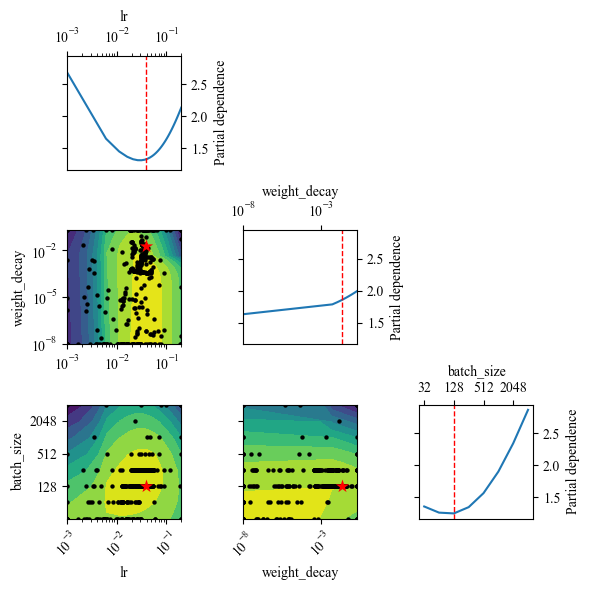

In [12]:
plt.figure()
ax = plot_objective(result)
plt.show()

In [13]:
ax[0, 0].get_lines()[0].set_color('k')

In [14]:
result.x

[0.03858073169465622, 0.01979435727033024, 128]

In [15]:
result.fun

0.8141782879829407